In [3]:
import gymnasium as gym
from gymnasium.vector import AsyncVectorEnv
import highway_env   # registers roundabout-v0
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque

In [4]:
kin_config = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
        "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"],
        "features_range": {
            "x":  [-100, 100],
            "y":  [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20]
        },
        "absolute": False,
        "order":    "sorted"
    }
}
feat2idx = {name: i for i, name in enumerate(kin_config["observation"]["features"])}
vx_idx   = feat2idx["vx"]
vy_idx   = feat2idx["vy"]

# 2) Hyper-parameters
env_id        = "roundabout-v0"
batch_size    = 64
max_steps     = 300
hidden_size   = 256
gamma         = 0.99
alpha         = 0.05
cost_limit    = 0.05
lr_policy     = 3e-4
lr_value      = 3e-4
lr_dual       = 1e-2
num_epochs    = 400
noise_scale   = 0.01
forward_coef  = 0.1
crash_penalty = 2.5
idle_thresh          = 0.1
idle_penalty_coef    = 0.2
accel_penalty_coef   = 0.005
num_adv_steps = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Failure-only buffer
class FailureBuffer:
    def __init__(self, capacity):
        self.buf = deque(maxlen=capacity)
    def push(self, *t):
        self.buf.append(t)
    def sample(self, n):
        idx = np.random.choice(len(self.buf), n, replace=False)
        return [self.buf[i] for i in idx]
    def __len__(self):
        return len(self.buf)

failure_buffer = FailureBuffer(50_000)

# Policy, Value, and Adversary nets
class PolicyNet(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden=hidden_size):
        super().__init__()
        self.fc1    = nn.Linear(obs_dim, hidden)
        self.fc2    = nn.Linear(hidden, hidden)
        self.fc3    = nn.Linear(hidden, hidden)
        self.logits = nn.Linear(hidden, action_dim)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return self.logits(h)
    def get_dist(self, x):
        return torch.distributions.Categorical(logits=self.forward(x))

class ValueNet(nn.Module):
    def __init__(self, obs_dim, hidden=hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.v   = nn.Linear(hidden, 1)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.v(h).squeeze(-1)

class AdvNet(nn.Module):
    def __init__(self, obs_dim, hidden=128, eps=0.05):
        super().__init__()
        self.eps = eps
        self.fc1 = nn.Linear(obs_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, obs_dim)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        delta = torch.tanh(self.fc3(h))
        return delta * self.eps

# 5) Build envs
def make_env():
    env = gym.make(env_id, config=kin_config)
    env.reset()
    return env

envs = AsyncVectorEnv([make_env for _ in range(batch_size)])
vc, nf      = envs.single_observation_space.shape
obs_dim     = vc * nf
action_dim  = envs.single_action_space.n

policy     = PolicyNet(obs_dim, action_dim).to(device)
value_net  = ValueNet(obs_dim).to(device)
adv_net    = AdvNet(obs_dim).to(device)

opt_pol  = torch.optim.Adam(policy.parameters(), lr=lr_policy)
opt_val  = torch.optim.Adam(value_net.parameters(),   lr=lr_value)
opt_adv  = torch.optim.Adam(adv_net.parameters(),     lr=1e-3)
opt_dual = torch.optim.Adam([torch.tensor(1., requires_grad=True, device=device),
                             torch.tensor(1., requires_grad=True, device=device)], lr=lr_dual)

lambda_cvar, mu_cost = opt_dual.param_groups[0]['params']

In [6]:
# 7) CVaR helper
def static_cvar(returns, α):
    sorted_r, _ = returns.sort()
    k           = max(1, int(α * sorted_r.numel()))
    return sorted_r[:k].mean()

def collect_batch(envs, policy, max_steps):
    out = envs.reset()
    obs = out[0] if isinstance(out, tuple) else out
    obs = torch.tensor(obs, dtype=torch.float32, device=device)

    logps_buf, rews_buf = [], []
    crashed   = torch.zeros(batch_size, dtype=torch.bool, device=device)
    done_mask = torch.zeros(batch_size, dtype=torch.bool, device=device)
    transitions = []

    # track previous speed for each env in the batch
    prev_speed = torch.zeros(batch_size, device=device)

    for _ in range(max_steps):
        # (FGSM adversary etc.)
        obs_adv  = obs.detach().clone().requires_grad_(True)
        flat_adv = obs_adv.view(batch_size, -1)
        dist_adv = policy.get_dist(flat_adv)
        a_adv    = dist_adv.sample()
        loss_adv = -dist_adv.log_prob(a_adv).mean()
        grads    = torch.autograd.grad(loss_adv, obs_adv)[0]
        obs      = (obs_adv + noise_scale * grads.sign()).detach()

        # policy step
        flat  = obs.view(batch_size, -1)
        dist  = policy.get_dist(flat)
        acts  = dist.sample()
        logps = dist.log_prob(acts)

        # step env
        step_out = envs.step(acts.cpu().numpy())
        if len(step_out) == 5:
            nxt, rews_raw, term, truncs, infos = step_out
            dones = np.logical_or(term, truncs)
        else:
            nxt, rews_raw, dones, infos = step_out
        dones = np.array(dones)
        done_mask |= torch.tensor(dones, device=device)

        # crash detection
        if isinstance(infos, dict):
            crash_np = np.array(infos.get("crashed", np.zeros(batch_size)), bool)
        elif isinstance(infos, list):
            crash_np = np.array([i.get("crashed",False) for i in infos], bool)
        else:
            crash_np = np.array(infos, bool)
        crashed |= torch.tensor(crash_np, device=device)

        # extract ego velocities BEFORE overwriting obs
        ego_vx = obs[:,0,vx_idx]
        ego_vy = obs[:,0,vy_idx]
        ego_speed = (ego_vx.pow(2) + ego_vy.pow(2)).sqrt()

        # NOW compute acceleration penalty
        accel     = ego_speed - prev_speed           
        accel_pen = accel.pow(2) * accel_penalty_coef
        prev_speed = ego_speed                       

        idle_gap = (idle_thresh - ego_speed).clamp(min=0)      
        idle_pen = idle_gap.pow(2) * idle_penalty_coef 

        # shape the reward
        base_r         = torch.tensor(rews_raw, device=device)
        crash_pen_term = crash_penalty * crash_np.astype(float)
        speed_bonus    = forward_coef * ego_speed
        r_t = base_r \
              - crash_pen_term \
              + speed_bonus \
              - accel_pen \
              - idle_pen
              

        logps_buf.append(logps)
        rews_buf.append(r_t)

        # record transition
        nxt_t    = torch.tensor(nxt, dtype=torch.float32, device=device)
        flat_nxt = nxt_t.view(batch_size, -1)
        for i in range(batch_size):
            transitions.append((
                flat[i].detach().cpu(),
                acts[i].item(),
                logps[i].detach().cpu(),
                float(r_t[i].item()),
                float(crash_np[i]),
                flat_nxt[i].cpu(),
                bool(dones[i])
            ))

        # next obs + a bit of noise
        obs = nxt_t + torch.randn_like(nxt_t)*(noise_scale*0.1)
        if done_mask.all():
            break

    # rest of function is unchanged...
    ep_C        = crashed.float()
    crash_count = int(crashed.sum().item())
    T = len(rews_buf)
    returns = torch.zeros(T, batch_size, device=device)
    G = torch.zeros(batch_size, device=device)
    for t in reversed(range(T)):
        G = rews_buf[t] + gamma * G
        returns[t] = G

    ep_R      = returns[0]
    all_logps = torch.cat(logps_buf)
    all_rets  = returns.flatten()
    return ep_R, ep_C, all_logps, all_rets, crash_count, transitions

# Modified train_epoch with adversary metrics
def train_epoch(envs, policy, epoch):
    # train adversary
    reset_out = envs.reset()
    obs0 = reset_out[0] if isinstance(reset_out, tuple) else reset_out
    obs0 = torch.tensor(obs0, device=device).view(batch_size, -1)

    adv_losses  = []
    delta_norms = []

    for _ in range(num_adv_steps):
        δ = adv_net(obs0)                         
        delta_norms.append(δ.abs().mean().item())
        dist_adv = policy.get_dist(obs0 + δ)
        acts_adv = dist_adv.sample()
        loss_adv = -dist_adv.log_prob(acts_adv).mean()
        adv_losses.append(loss_adv.item())

        opt_adv.zero_grad()
        loss_adv.backward()
        opt_adv.step()

    adv_loss  = float(np.mean(adv_losses))
    avg_delta = float(np.mean(delta_norms))

    # rollout
    ep_R, ep_C, logps_o, rets_o, crash_count, trans = \
        collect_batch(envs, policy, max_steps)

    # store failures
    if crash_count > 0:
        for tr in trans:
            failure_buffer.push(*tr)

    # on‐policy surrogate & cost
    baseline  = rets_o.mean().detach()
    adv_on    = rets_o - baseline
    loss_on   = - (logps_o * adv_on).mean()
    cost_on   = ep_C.mean()

    # pure failure‐buffer update on even epochs
    use_fail = (epoch % 2 == 0) and (len(failure_buffer) >= batch_size)
    if use_fail:
        batch = failure_buffer.sample(batch_size)
        s_f, a_f, lp_old, r_f, c_f, nxt_f, d_f = zip(*batch)
        s_f    = torch.stack(s_f).to(device)
        a_f    = torch.tensor(a_f, device=device)
        lp_old = torch.stack(lp_old).to(device)
        r_f    = torch.tensor(r_f, device=device)

        dist_f   = policy.get_dist(s_f)
        lp_new   = dist_f.log_prob(a_f)
        with torch.no_grad():
            w = (lp_new - lp_old).exp().clamp(max=10.0)

        adv_f     = r_f - r_f.mean().detach()
        loss_surr = - (w * lp_new * adv_f).mean()
        avg_cost  = cost_on
    else:
        loss_surr = loss_on
        avg_cost  = cost_on

    # CVaR + crash‐rate penalty
    cvar       = static_cvar(ep_R, alpha)
    slack      = avg_cost - cost_limit
    hinge_slack= torch.clamp(slack, min=0.0)
    cost_pen   = mu_cost * hinge_slack**2

    # 7) policy update
    L = loss_surr - lambda_cvar * cvar + cost_pen
    opt_pol.zero_grad()
    L.backward()
    torch.nn.utils.clip_grad_norm_(policy.parameters(), 0.5)
    opt_pol.step()

    # 8) dual ascent on μ
    opt_dual.zero_grad()
    dual_loss = - mu_cost * hinge_slack**2
    dual_loss.backward()
    opt_dual.step()
    mu_cost.data.clamp_(0.0, 50.0)

    return (
        float(ep_R.mean().item()),
        float(cvar.item()),
        float(avg_cost.item()),
        float(mu_cost.item()),
        int(crash_count),
        adv_loss,
        avg_delta
    )

running:  0
Epoch:  0
Epoch:  10
Epoch:  20
Epoch:  30
Epoch:  40
Epoch:  50
Epoch:  60
Epoch:  70
Epoch:  80
Epoch:  90
Epoch:  100
Epoch:  110
Epoch:  120
Epoch:  130
Epoch:  140
Epoch:  150
Epoch:  160
Epoch:  170
Epoch:  180
Epoch:  190
Epoch:  200
Epoch:  210
Epoch:  220
Epoch:  230
Epoch:  240
Epoch:  250
Epoch:  260
Epoch:  270
Epoch:  280
Epoch:  290
Epoch:  300
Epoch:  310
Epoch:  320
Epoch:  330
Epoch:  340
Epoch:  350
Epoch:  360
Epoch:  370
Epoch:  380
Epoch:  390
running:  1
Epoch:  0
Epoch:  10
Epoch:  20
Epoch:  30
Epoch:  40
Epoch:  50
Epoch:  60
Epoch:  70
Epoch:  80
Epoch:  90
Epoch:  100
Epoch:  110
Epoch:  120
Epoch:  130
Epoch:  140
Epoch:  150
Epoch:  160
Epoch:  170
Epoch:  180
Epoch:  190
Epoch:  200
Epoch:  210
Epoch:  220
Epoch:  230
Epoch:  240
Epoch:  250
Epoch:  260
Epoch:  270
Epoch:  280
Epoch:  290
Epoch:  300
Epoch:  310
Epoch:  320
Epoch:  330
Epoch:  340
Epoch:  350
Epoch:  360
Epoch:  370
Epoch:  380
Epoch:  390
running:  2
Epoch:  0
Epoch:  10
Epoch

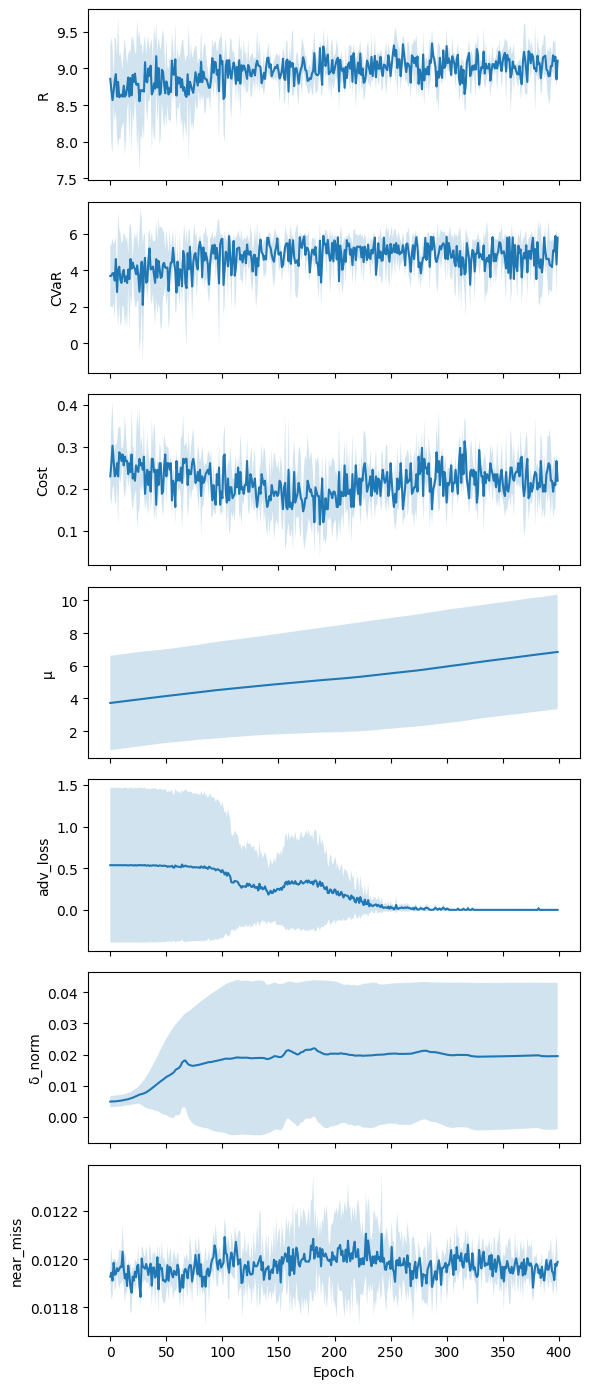

In [9]:
import gymnasium as gym
from gymnasium.vector import AsyncVectorEnv
import highway_env   # registers roundabout-v0
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque

# 1) Kinematics obs config + feature→index map
kin_config = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
        "features": ["presence","x","y","vx","vy","cos_h","sin_h"],
        "features_range":{
            "x":[-100,100],"y":[-100,100],
            "vx":[-20,20],"vy":[-20,20]
        },
        "absolute":False,"order":"sorted"
    }
}
feat2idx = {n:i for i,n in enumerate(kin_config["observation"]["features"])}
vx_idx, vy_idx = feat2idx["vx"], feat2idx["vy"]

# 2) Hyper-parameters
env_id        = "roundabout-v0"
batch_size    = 64
max_steps     = 300
hidden_size   = 256
gamma         = 0.99
alpha         = 0.05
cost_limit    = 0.05
lr_policy     = 3e-4
lr_dual       = 1e-2
num_epochs    = 400
noise_scale   = 0.01
forward_coef  = 0.1
crash_penalty = 2.5
idle_thresh   = 0.1
idle_penalty_coef = 0.2
accel_penalty_coef = 0.1
num_adv_steps = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3) Failure-only buffer
class FailureBuffer:
    def __init__(self, capacity): self.buf = deque(maxlen=capacity)
    def push(self,*t):            self.buf.append(t)
    def sample(self,n):
        idx = np.random.choice(len(self.buf), n, replace=False)
        return [self.buf[i] for i in idx]
    def __len__(self): return len(self.buf)

failure_buffer = FailureBuffer(50_000)

# 4) Nets
class PolicyNet(nn.Module):
    def __init__(self,obs_dim,ac_dim,hidden=hidden_size):
        super().__init__()
        self.fc1=nn.Linear(obs_dim,hidden)
        self.fc2=nn.Linear(hidden,hidden)
        self.fc3=nn.Linear(hidden,hidden)
        self.logits=nn.Linear(hidden,ac_dim)
    def forward(self,x):
        h=F.relu(self.fc1(x)); h=F.relu(self.fc2(h)); h=F.relu(self.fc3(h))
        return self.logits(h)
    def get_dist(self,x):
        return torch.distributions.Categorical(logits=self(x))

class AdvNet(nn.Module):
    def __init__(self,obs_dim,hidden=128,eps=0.05):
        super().__init__()
        self.eps=eps
        self.fc1=nn.Linear(obs_dim,hidden)
        self.fc2=nn.Linear(hidden,hidden)
        self.fc3=nn.Linear(hidden,obs_dim)
    def forward(self,x):
        h=F.relu(self.fc1(x)); h=F.relu(self.fc2(h))
        return torch.tanh(self.fc3(h))*self.eps

# 5) Helpers
def static_cvar(returns,α):
    sorted_r,_=returns.sort()
    k=max(1,int(α*sorted_r.numel()))
    return sorted_r[:k].mean()

# 6) Build envs
def make_env():
    e=gym.make(env_id,config=kin_config); e.reset(); return e

envs = AsyncVectorEnv([make_env for _ in range(batch_size)])
vc,nf = envs.single_observation_space.shape
obs_dim,ac_dim = vc*nf, envs.single_action_space.n

# 7) Instantiate
policy   = PolicyNet(obs_dim,ac_dim).to(device)
adv_net  = AdvNet(obs_dim).to(device)
opt_pol  = torch.optim.Adam(policy.parameters(),lr=lr_policy)
opt_adv  = torch.optim.Adam(adv_net.parameters(),lr=1e-3)
lambda_cvar = torch.tensor(1.0,requires_grad=True,device=device)
mu_cost     = torch.tensor(1.0,requires_grad=True,device=device)
opt_dual    = torch.optim.Adam([lambda_cvar,mu_cost],lr=lr_dual)

# 8) collect_batch (now with near-miss)
def collect_batch(envs, policy, max_steps):
    # 1) Reset envs
    out = envs.reset()
    obs = out[0] if isinstance(out, tuple) else out
    obs = torch.tensor(obs, dtype=torch.float32, device=device)  # shape (B, V, F) or sometimes (B, obs_dim)

    # 2) Buffers and trackers
    logps       = []
    rews        = []
    crashed     = torch.zeros(batch_size, dtype=torch.bool, device=device)
    done_mask   = torch.zeros(batch_size, dtype=torch.bool, device=device)
    transitions = []

    # near-miss: start at +∞ so any real dist is smaller
    near        = torch.full((batch_size,), float("inf"), device=device)
    prev_speed  = torch.zeros(batch_size, device=device)

    for _ in range(max_steps):
        # — FGSM adversary on obs —
        obs_adv    = obs.detach().clone().requires_grad_(True)
        flat_adv   = obs_adv.view(batch_size, -1)
        dist_adv   = policy.get_dist(flat_adv)
        a_adv      = dist_adv.sample()
        Ladv       = -dist_adv.log_prob(a_adv).mean()
        g          = torch.autograd.grad(Ladv, obs_adv)[0]
        obs        = (obs_adv + noise_scale * g.sign()).detach()

        # — policy forward —
        flat       = obs.view(batch_size, -1)
        dist       = policy.get_dist(flat)
        acts       = dist.sample()
        lp         = dist.log_prob(acts)

        # — step the envs —
        step_out = envs.step(acts.cpu().numpy())
        if len(step_out) == 5:
            nxt, raw, term, trunc, infos = step_out
            dones = np.logical_or(term, trunc)
        else:
            nxt, raw, dones, infos = step_out

        dones     = np.array(dones)
        done_mask |= torch.tensor(dones, device=device)

        # — crash detection —
        if isinstance(infos, dict):
            c_np = np.array(infos.get("crashed", np.zeros(batch_size)), bool)
        else:
            c_np = np.array([i.get("crashed", False) for i in infos], bool)
        crashed |= torch.tensor(c_np, device=device)

        # — ensure obs is B×V×F —
        if obs.ndim == 2:
            obs3 = obs.view(batch_size, vc, nf)
        else:
            obs3 = obs

        # — near-miss: min distance to any present vehicle —
        pres      = obs3[:, :, 0]              # presence flag
        xy        = obs3[:, :, 1:3]            # x,y
        d2        = torch.norm(xy, dim=-1)     # (B, V)
        d2        = torch.where(pres > 0, d2, float("inf"))
        near      = torch.min(near, d2.min(dim=1)[0])

        # — speeds + penalties —
        vx        = obs3[:, 0, vx_idx]
        vy        = obs3[:, 0, vy_idx]
        sp        = torch.sqrt(vx.pow(2) + vy.pow(2))

        accel     = sp - prev_speed
        accel_pen = accel.pow(2) * accel_penalty_coef
        prev_speed = sp

        idle_gap  = (idle_thresh - sp).clamp(min=0)
        idle_pen  = idle_gap.pow(2) * idle_penalty_coef

        # — reward shaping —
        base_r     = torch.tensor(raw, device=device)
        crash_pen  = crash_penalty * c_np.astype(float)
        speed_bonus= forward_coef * sp
        rt         = base_r - crash_pen + speed_bonus - accel_pen - idle_pen

        # — record logs & transitions —
        logps.append(lp)
        rews.append(rt)

        nxt_t    = torch.tensor(nxt, dtype=torch.float32, device=device)
        flat_nxt = nxt_t.view(batch_size, -1)
        for i in range(batch_size):
            transitions.append((
                flat[i].detach().cpu(),      # state
                acts[i].item(),              # action
                lp[i].detach().cpu(),        # old log-prob
                float(rt[i].item()),         # shaped reward
                float(c_np[i]),              # immediate crash-cost
                flat_nxt[i].cpu(),           # next state
                bool(dones[i])               # done flag
            ))

        obs = nxt_t + torch.randn_like(nxt_t) * (noise_scale * 0.1)
        if done_mask.all():
            break

    # — pack up episode stats —
    ep_C        = crashed.float()              # per-env cost
    crash_count = int(crashed.sum().item())

    # discounted returns
    T       = len(rews)
    returns = torch.zeros(T, batch_size, device=device)
    G       = torch.zeros(batch_size, device=device)
    for t in reversed(range(T)):
        G = rews[t] + gamma * G
        returns[t] = G

    ep_R      = returns[0]                     # per-env return
    all_logps = torch.cat(logps)               # (T*B,)
    all_rets  = returns.flatten()              # (T*B,)

    near_mean = float(near.mean().item())      # average nearest-neighbor per batch

    return ep_R, ep_C, all_logps, all_rets, crash_count, transitions, near_mean


# 9) train_epoch → return adv and near-miss
def train_epoch(envs,policy,epoch):
    # a) adversary update
    o0=envs.reset()[0]; o0=torch.tensor(o0,device=device).view(batch_size,-1)
    adv_ls,del_norms=[],[]
    for _ in range(num_adv_steps):
        δ=adv_net(o0); del_norms.append(δ.abs().mean().item())
        d=policy.get_dist(o0+δ); a=d.sample(); la=d.log_prob(a).mean()
        la=-la; adv_ls.append(la.item())
        opt_adv.zero_grad(); la.backward(); opt_adv.step()
    adv_loss,avg_delta = np.mean(adv_ls),np.mean(del_norms)

    # b) rollout
    ep_R, ep_C, lp, rets, cc, trans, near_mean = collect_batch(envs, policy, max_steps)
    if cc>0:
        for t in trans: failure_buffer.push(*t)

    # c) on‐policy surrogate
    baseline=rets.mean().detach()
    loss_on=-(lp*(rets-baseline)).mean()
    cost_on=ep_C.mean()

    # d) failure‐buffer update every other epoch
    use_fail=(epoch%2==0 and len(failure_buffer)>=batch_size)
    if use_fail:
        batch=failure_buffer.sample(batch_size)
        s_f,a_f,lp_old,r_f,c_f,n_f,d_f=zip(*batch)
        s_f=torch.stack(s_f).to(device)
        a_f=torch.tensor(a_f,device=device)
        lp_old=torch.stack(lp_old).to(device)
        r_f=torch.tensor(r_f,device=device)
        d_new=policy.get_dist(s_f).log_prob(a_f)
        with torch.no_grad():
            w=(d_new-lp_old).exp().clamp(max=10.0)
        loss_surr=-(w*d_new*(r_f-r_f.mean().detach())).mean()
        avg_cost=cost_on
    else:
        loss_surr,avg_cost=loss_on,cost_on

    # e) CVaR & cost‐penalty
    cvar=static_cvar(ep_R,alpha)
    slack=(avg_cost-cost_limit).clamp(min=0)
    cost_pen=mu_cost*slack.pow(2)

    # f) policy update
    L=loss_surr - lambda_cvar*cvar + cost_pen
    opt_pol.zero_grad(); L.backward()
    torch.nn.utils.clip_grad_norm_(policy.parameters(),0.5)
    opt_pol.step()

    # g) dual asc
    opt_dual.zero_grad()
    dl=-mu_cost*slack.pow(2); dl.backward()
    opt_dual.step()
    mu_cost.data.clamp_(0,50)

    return (
        float(ep_R.mean().item()),
        float(static_cvar(ep_R, alpha).item()),
        float(ep_C.mean().item()),
        float(mu_cost.item()),
        int(cc),
        adv_loss,
        avg_delta,
        near_mean
    )

# 10) Multi-seed run + aggregation
def run_seed(seed):
    print("running: ", seed)
    torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
    # re-init nets & opt here if you want fresh
    logs=[]
    for ep in range(num_epochs):
        logs.append(train_epoch(envs,policy,ep))
        if ep % 10 == 0:
            print("Epoch: ", ep)
    cols=["R","CVaR","Cost","μ","crashes",
          "adv_loss","δ_norm","near_miss"]
    return pd.DataFrame(logs,columns=cols)

all_dfs = [run_seed(s) for s in [0,1,2]]
# compute mean ± std
mean_df = pd.concat(all_dfs,keys=[0,1,2]).groupby(level=1).mean()
std_df  = pd.concat(all_dfs,keys=[0,1,2]).groupby(level=1).std()

# 11) Plot
metrics = ["R","CVaR","Cost","μ","adv_loss","δ_norm","near_miss"]
fig,axes=plt.subplots(len(metrics),1,figsize=(6,2*len(metrics)),sharex=True)
for i,m in enumerate(metrics):
    axes[i].plot(mean_df[m],label=m)
    axes[i].fill_between(mean_df.index,
                         mean_df[m]-std_df[m],
                         mean_df[m]+std_df[m],
                         alpha=0.2)
    axes[i].set_ylabel(m)
axes[-1].set_xlabel("Epoch")
plt.tight_layout()
plt.show()
